Mount the Google Drive (if we need to access any data there)

In [1]:
# Mount the Google Drive so we can access data
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Install s3fs in order to access the data in the AWS S3 bucket ('s3://cs7643-fastmri/data/')

In [2]:
!pip install s3fs
!pip install fastmri

import fastmri
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

import h5py
import s3fs
from tqdm import tqdm
from datetime import datetime
import gc  # Garbage collection

     |████████████████████████████████| 132 kB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 18.4 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 8.1 MB 38.5 MB/s 
     |████████████████████████████████| 271 kB 69.1 MB/s 
     |████████████████████████████████| 192 kB 64.2 MB/s 
     |████████████████████████████████| 160 kB 63.2 MB/s 
     |████████████████████████████████| 138 kB 64.4 MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-2.0.1-py3-none-any.whl size=51992 sha256=986f87ccdf6f0925f543e873ef62e4b02ea93c08e5b124fbd8c274469cc50003
  Stored in directory: /root/.cache/pip/wheels/56/cd/99/917ef1080ec8cc6f1c903f4622761689c3886bc49306855a0e
Successfully built aiobotocore
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the pack

Connect to the S3 bucket with the brain fastMRI train data and get the list of FLAIR MRI files.

In [3]:
typename = 'AXFLAIR'
datacat = 'TRAIN'
s3 = s3fs.S3FileSystem(anon=True)
train_list = s3.ls('s3://cs7643-fastmri/data/multicoil_train/')
print('train num', len(train_list))
print('train list', train_list)
flair_train_list = [s for s in train_list if typename in s]
# flair_train_list = flair_train_list[-44:]
print('FLAIR num', len(flair_train_list))
print('FLAIR list', flair_train_list)

train num 1592
train list ['cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002425.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002428.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002429.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002435.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002442.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002452.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002456.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002458.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002460.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002466.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002467.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002469.h5', 'cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_200_6002474.h5', 'cs7643-fastmri/data/mul

Set up some stuff.

In [4]:
cols = ['file_number', 'image', 'source_file', 'type', 'slice', 'center_fractions', 'accelerations', 'height', 'width', 'orig_h', 'orig_w']  # Fields for the info .csv file
CF = 0.04  # Center fractions, for the subsampling
ACCEL = 4  # Accelerations, for the subsampling, should be 4 or 8
resolution = 300
h = resolution #400 #640 # Height
w = resolution #250 #320 # Width

df = pd.DataFrame(columns=cols)
small_files = []
axflair_full = np.zeros((0,h,w))
axflair_subsampled = np.zeros((0,h,w))
print(axflair_full)

[]


Loop through each element of the FLAIR train list, perform the transforms, and append to 3 structures - the pd dataframe with the file info, the numpy with the full resolution brain slices, and the numpy with the subsampled brain slices.

In [ ]:
file_num = 0
image = 0

for filename in tqdm(flair_train_list):
  hf = h5py.File(s3.open(filename, 'rb'))
  file_num += 1
  
  volume_kspace = hf['kspace'][()]
  for slic in tqdm(range(volume_kspace.shape[0])):  # In multi-coil MRIs, k-space has the following shape: (number of slices, number of coils, height, width)
    image += 1
    slice_kspace = volume_kspace[slic]
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor

    # First do the full resolution image
    slice_image = fastmri.ifft2c(slice_kspace2)      # Apply Inverse Fourier Transform to get the complex image
    oh = slice_image.shape[1]
    ow = slice_image.shape[2]
    if slice_image.shape[1] < resolution: h = slice_image.shape[1]
    else: h = resolution
    if slice_image.shape[2] < resolution: w = slice_image.shape[2]
    else: w = resolution
    slice_image = T.complex_center_crop(slice_image, (h, w))  # Crop complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    slice_image_rss = np.abs(fastmri.rss(slice_image_abs, dim=0).numpy())
    # Pad image if necessary
    pad_h = int((resolution - h) / 2)
    pad_w = int((resolution - w) / 2)
    if oh % 2 == 0: h_offset = 0
    else: h_offset = 1
    if ow % 2 == 0: w_offset = 0
    else: w_offset = 1
    slice_image_rss = np.pad(slice_image_rss, ((pad_h, pad_h+h_offset), (pad_w, pad_w+w_offset)), mode='constant', constant_values=0)
    axflair_full = np.vstack((axflair_full, np.expand_dims(slice_image_rss, 0)))

    # Next do the subsampling
    mask_func = RandomMaskFunc(center_fractions=[CF], accelerations=[ACCEL])  # Create the mask function object
    masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
    sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
    sampled_image = T.complex_center_crop(sampled_image, (h, w))  # Crop complex image
    sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
    sampled_image_rss = np.abs(fastmri.rss(sampled_image_abs, dim=0).numpy())
    # Pad image if necessary
    sampled_image_rss = np.pad(sampled_image_rss, ((pad_h, pad_h+h_offset), (pad_w, pad_w+w_offset)), mode='constant', constant_values=0)
    axflair_subsampled = np.vstack((axflair_subsampled, np.expand_dims(sampled_image_rss, 0)))

    # Save the metadata into a dataframe
    record = pd.DataFrame([[file_num, image, filename, typename, slic, CF, ACCEL, h, w, oh, ow]], columns=cols)
    df = df.append(record)

  if file_num % 50 == 0: # Save everything
    # Save the two H5 files and the dataframe with metadata
    dt = datetime.now()
    ts = str(datetime.timestamp(dt))  # Get timestamp
    basefolder = '/content/drive/My Drive/CS7643_Project/Data/preprocessed/'

    with h5py.File(basefolder+'brain_'+typename+'_'+'full'+'_'+datacat+'_'+ts+'.h5', 'w') as hf: hf.create_dataset('full_train',  data=axflair_full)
    with h5py.File(basefolder+'brain_'+typename+'_'+'subsampled'+'_'+datacat+'_'+ts+'.h5', 'w') as hf: hf.create_dataset('subsample_train',  data=axflair_subsampled)
    df.reset_index(drop=True).to_csv(basefolder+'brain_'+typename+'_'+datacat+'_'+ts+'.csv', header=True, sep='|', index=False)

  # Do some cleanup
  del volume_kspace, hf
  gc.collect()

print(axflair_full.shape, axflair_subsampled.shape, df.shape)

  4%|▍         | 15/344 [16:38<3:12:51, 35.17s/it]

In [ ]:
print(filename)
print(oh, ow)

cs7643-fastmri/data/multicoil_train/file_brain_AXFLAIR_210_6001957.h5
640 320


In [ ]:
#print(filename)
#print(axflair_full.shape, np.expand_dims(slice_image_rss, 0).shape)

In [ ]:
#plt.imshow(slice_image_rss, cmap='gray')

In [ ]:
#print(axflair_full.shape, axflair_subsampled.shape, df.shape)
#print(axflair_full)
#print(axflair_subsampled)
#df.reset_index(drop=True).tail()

In [ ]:
# Save the two H5 files and the dataframe with metadata
dt = datetime.now()
ts = str(datetime.timestamp(dt))  # Get timestamp
basefolder = '/content/drive/My Drive/CS7643_Project/Data/preprocessed/'

with h5py.File(basefolder+'brain_'+typename+'_'+'full2'+'_'+datacat+'_'+ts+'.h5', 'w') as hf: hf.create_dataset('full_train',  data=axflair_full)
with h5py.File(basefolder+'brain_'+typename+'_'+'subsampled2'+'_'+datacat+'_'+ts+'.h5', 'w') as hf: hf.create_dataset('subsample_train',  data=axflair_subsampled)
df.reset_index(drop=True).to_csv(basefolder+'brain_'+typename+'_2'+datacat+'_'+ts+'.csv', header=True, sep='|', index=False)

In [5]:
# Read them back in
basefolder = '/content/drive/My Drive/CS7643_Project/Data/preprocessed/'

hff = h5py.File(basefolder+'brain_AXFLAIR_full_TRAIN_1637456991.970846.h5', 'r')
train_full = np.array(hff['full_train'])
hfs = h5py.File(basefolder+'brain_AXFLAIR_full_TRAIN_1638189812.182278_EXTRA44.h5', 'r')
train_ss = np.array(hfs['full_train'])
print(train_full.shape, train_ss.shape)

(4754, 300, 300) (702, 300, 300)


In [6]:
# combine the two sets together:
arr = np.zeros((5456,300,300))   
row1 = 0
for h5name in [basefolder+'brain_AXFLAIR_full_TRAIN_1637456991.970846.h5', basefolder+'brain_AXFLAIR_full_TRAIN_1638189812.182278_EXTRA44.h5']:
  h5fr = h5py.File(h5name,'r')
  print(f"keys: {list(h5fr.keys())}")
  dset1 = list(h5fr.keys())[0]
  arr_data = h5fr[dset1][:]
  print(f"shape: {arr_data.shape}")
  
  arr[row1:row1+arr_data.shape[0],:] = arr_data[:]
  row1 += arr_data.shape[0]

with h5py.File(basefolder+'table_merge.h5', 'w') as hf: hf.create_dataset('full_train',  data=arr_data)


keys: ['full_train']
shape: (4754, 300, 300)
keys: ['full_train']
shape: (702, 300, 300)


In [ ]:
hff = h5py.File(basefolder+'table_merge.h5', 'r')
train_full = np.array(hff['full_train'])
print(train_full.shape)

(4754, 300, 300)


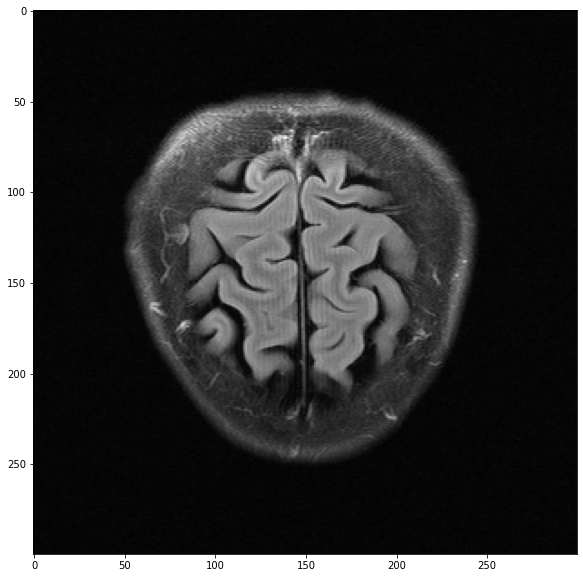

In [ ]:
plt.imshow(train_full[10], cmap='gray')

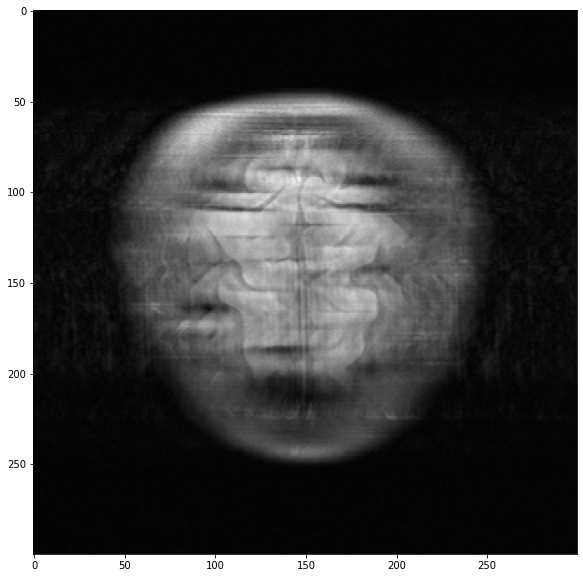

In [ ]:
plt.imshow(train_ss[10], cmap='gray')

Next do the validation set

In [ ]:
typename = 'AXFLAIR'
datacat = 'VAL'
s3 = s3fs.S3FileSystem(anon=True)
val_list = s3.ls('s3://cs7643-fastmri/data/multicoil_val/')
print('val num', len(val_list))
#print('val list', val_list)
flair_val_list = [s for s in val_list if typename in s]
print('FLAIR num', len(flair_val_list))
print('FLAIR list', flair_val_list)

val num 1378
FLAIR num 107
FLAIR list ['cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002447.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002462.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002471.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002477.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002483.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002499.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002536.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002556.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002560.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002562.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002572.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002574.h5', 'cs7643-fastmri/data/multicoil_val/file_brain_AXFLAIR_200_6002581.h5', 'cs7643-fastmri/data/multicoil_val/fil

In [ ]:
cols = ['file_number', 'image', 'source_file', 'type', 'slice', 'center_fractions', 'accelerations', 'height', 'width', 'orig_h', 'orig_w']  # Fields for the info .csv file
CF = 0.04  # Center fractions, for the subsampling
ACCEL = 4  # Accelerations, for the subsampling, should be 4 or 8
resolution = 300
h = resolution #400 #640 # Height
w = resolution #250 #320 # Width

df = pd.DataFrame(columns=cols)
small_files = []
axflair_full = np.zeros((0,h,w))
axflair_subsampled = np.zeros((0,h,w))
print(axflair_full)

[]


In [ ]:
file_num = 0
image = 0

for filename in tqdm(flair_val_list):
  hf = h5py.File(s3.open(filename, 'rb'))
  file_num += 1
  
  volume_kspace = hf['kspace'][()]
  for slic in tqdm(range(volume_kspace.shape[0])):  # In multi-coil MRIs, k-space has the following shape: (number of slices, number of coils, height, width)
    image += 1
    slice_kspace = volume_kspace[slic]
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor

    # First do the full resolution image
    slice_image = fastmri.ifft2c(slice_kspace2)      # Apply Inverse Fourier Transform to get the complex image
    oh = slice_image.shape[1]
    ow = slice_image.shape[2]
    if slice_image.shape[1] < resolution: h = slice_image.shape[1]
    else: h = resolution
    if slice_image.shape[2] < resolution: w = slice_image.shape[2]
    else: w = resolution
    slice_image = T.complex_center_crop(slice_image, (h, w))  # Crop complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    slice_image_rss = np.abs(fastmri.rss(slice_image_abs, dim=0).numpy())
    # Pad image if necessary
    pad_h = int((resolution - h) / 2)
    pad_w = int((resolution - w) / 2)
    if oh % 2 == 0: h_offset = 0
    else: h_offset = 1
    if ow % 2 == 0: w_offset = 0
    else: w_offset = 1
    slice_image_rss = np.pad(slice_image_rss, ((pad_h, pad_h+h_offset), (pad_w, pad_w+w_offset)), mode='constant', constant_values=0)
    axflair_full = np.vstack((axflair_full, np.expand_dims(slice_image_rss, 0)))

    # Next do the subsampling
    mask_func = RandomMaskFunc(center_fractions=[CF], accelerations=[ACCEL])  # Create the mask function object
    masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
    sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
    sampled_image = T.complex_center_crop(sampled_image, (h, w))  # Crop complex image
    sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
    sampled_image_rss = np.abs(fastmri.rss(sampled_image_abs, dim=0).numpy())
    # Pad image if necessary
    sampled_image_rss = np.pad(sampled_image_rss, ((pad_h, pad_h+h_offset), (pad_w, pad_w+w_offset)), mode='constant', constant_values=0)
    axflair_subsampled = np.vstack((axflair_subsampled, np.expand_dims(sampled_image_rss, 0)))

    # Save the metadata into a dataframe
    record = pd.DataFrame([[file_num, image, filename, typename, slic, CF, ACCEL, h, w, oh, ow]], columns=cols)
    df = df.append(record)

  if file_num % 50 == 0: # Save everything
    # Save the two H5 files and the dataframe with metadata
    dt = datetime.now()
    ts = str(datetime.timestamp(dt))  # Get timestamp
    basefolder = '/content/drive/My Drive/CS7643_Project/Data/preprocessed/'

    with h5py.File(basefolder+'brain_'+typename+'_'+'full'+'_'+datacat+'_'+ts+'.h5', 'w') as hf: hf.create_dataset('full_val',  data=axflair_full)
    with h5py.File(basefolder+'brain_'+typename+'_'+'subsampled'+'_'+datacat+'_'+ts+'.h5', 'w') as hf: hf.create_dataset('subsample_val',  data=axflair_subsampled)
    df.reset_index(drop=True).to_csv(basefolder+'brain_'+typename+'_'+datacat+'_'+ts+'.csv', header=True, sep='|', index=False)

  # Do some cleanup
  del volume_kspace, hf
  gc.collect()

print(axflair_full.shape, axflair_subsampled.shape, df.shape)

100%|██████████| 107/107 [46:50<00:00, 26.27s/it]

(1694, 300, 300) (1694, 300, 300) (1694, 11)


In [ ]:
# Save the two H5 files and the dataframe with metadata
dt = datetime.now()
ts = str(datetime.timestamp(dt))  # Get timestamp
basefolder = '/content/drive/My Drive/CS7643_Project/Data/preprocessed/'

with h5py.File(basefolder+'brain_'+typename+'_'+'full'+'_'+datacat+'_'+ts+'.h5', 'w') as hf: hf.create_dataset('full_val',  data=axflair_full)
with h5py.File(basefolder+'brain_'+typename+'_'+'subsampled'+'_'+datacat+'_'+ts+'.h5', 'w') as hf: hf.create_dataset('subsample_val',  data=axflair_subsampled)
df.reset_index(drop=True).to_csv(basefolder+'brain_'+typename+'_'+datacat+'_'+ts+'.csv', header=True, sep='|', index=False)